# UNET - Train on Fashion Dataset


This notebook shows how to train UNET on the Fashion dataset.

### The Dataset Object
This notebook will implement a Dataset object from the mcrnn implementation.  The dataset object holds a listing of all relevant data needed for training images and respective masks.  The object holds file references to the images and encoded masks for semantic segmentation.

The same dataset object used for training the MRCNN implementation is used in this workbook.  This helps to compare numerous implementation results by ensureing the same training data is used.

### UNET
UNET is a model that will produce a semantic segmentation based on an input image.  UNET acts as an encoder by using CNN's and Max Pooling to create an encoder and uses Upscaling and CNN's to decode.  UNET will output a sementaic segmentation of the same dimension as the input.  Each channel of the output is a binary mask for a segmentation class.  UNET's key feature is that the final output from each layer is concatenated with the corresponding layer on the decoding side.  The key feature allows the decoder to better represent more complex shape in the segmentation.  

### Limitations
#### Semantic Segmentation Only
UNET in its basic form will only output a semantic segmenation.  No boxing or instance identification is included.  This will increase the speed of training, but limits it use.

#### Fixed Dimensions
A UNET model is compiled with a fixed input dimension which drives a fixed output dimension.  Any training images or inferrence images will need to have the specificed input dimension.  MRCNN is more flexible and allows an input image of any size.


<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>



## Unet Architecture
![title](Unet_architecture.png)

### Setup local variables

In [13]:
import os, sys

project_root = "/Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/computer-vision-project"
data_dir     = '../../../data/FashionDataSet/'
train_dir    = os.path.join(data_dir, 'train')
images_file  = os.path.join(data_dir, 'train.csv' )
cat_file     = os.path.join(data_dir, 'label_descriptions.json' )
sys.path.append(project_root) # to capture FashtionDataset class
os.path.isdir(data_dir), os.path.isdir(train_dir), os.path.isfile(images_file), os.path.isfile(images_file)

(True, True, True, True)

## Set Backend For GPU Support
This can be commented out if an Nvidia GPU is being used or if processing is to be done using local CPUs

In [14]:
import os
# fix libiomp5.dylib error for mac
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# OPTIONAL SETTING
# Here we override the keras backend env variable to use plaidml
# plaidml can make use of AMD GPUs 
# This assignment needs to be added before loading keras libraries


# import plaidml.keras
# plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# to install plaidML, activate appropriate environment and then:
#   pip install -U plaidml-keras
#   plaidml-setup


### Load Modules

In [15]:
import warnings
warnings.filterwarnings('ignore')

import datetime, os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import seaborn as sns

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random
from sklearn.model_selection import train_test_split
import pickle
from skimage.transform import resize

import FashionUtils.FashionDataset as FashionDataset#import FashionDataset, create_datasets, load_dataset, save_dataset

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# from mrcnn.config import Config
from mrcnn import utils
# import mrcnn.model as modellib
from mrcnn import visualize
# from mrcnn.model import log
from mrcnn.visualize import display_images

%matplotlib inline 

In [16]:
# Keras imports
if os.environ.get("KERAS_BACKEND") == "plaidml.keras.backend":
    print("Loading PlaidML libraries for Keras.")
    import keras
    
    from keras.models import Model, load_model, model_from_json
    from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from keras.layers.core import Lambda, RepeatVector, Reshape
    from keras.layers.convolutional import Conv2D, Conv2DTranspose
    from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from keras.layers.merge import concatenate, add
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from keras.optimizers import Adam, SGD
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.utils import to_categorical
    from keras.layers import UpSampling2D
    from keras.preprocessing import image
    from keras.applications.resnet_v2 import ResNet152V2

else:
    print("Loading Tensorflow libraries for Keras.")
    import tensorflow as tf

    from tensorflow.python.keras.models import Model, load_model, model_from_json
    from tensorflow.python.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from tensorflow.python.keras.layers.core import Lambda, RepeatVector, Reshape
    from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
    from tensorflow.python.keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from tensorflow.python.keras.layers.merge import concatenate, add
    from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from tensorflow.python.keras.optimizers import Adam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from tensorflow.python.keras.utils import to_categorical
    from tensorflow.python.keras.layers import UpSampling2D
    from tensorflow.python.keras.preprocessing import image
    from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2
    

Loading PlaidML libraries for Keras.


### Load FasionDataset Objects
If you have saved the datasets, you can load them, it resplit and build them again.

In [17]:
# NOTE: There are 300k line images in the full training list
# fash_train, fash_val = FashionDataset.create_datasets( images_file=images_file, 
#                                         cat_file=cat_file,
#                                         images_dir=train_dir,
#                                         split=0.9, 
#                                         limit=150000)

# FashionDataset.save_dataset(fash_train, os.path.join(data_dir, 'fashion_train_dataset_75k.pkl'))
# FashionDataset.save_dataset(fash_val,   os.path.join(data_dir, 'fashion_val_dataset_75k.pkl'))

In [18]:
fash_train = FashionDataset.load_dataset(os.path.join(data_dir, 'fashion_train_dataset_75k.pkl'))
fash_val   = FashionDataset.load_dataset(os.path.join(data_dir, 'fashion_val_dataset_75k.pkl'))

../../../data/FashionDataSet/fashion_train_dataset_75k.pkl
../../../data/FashionDataSet/fashion_val_dataset_75k.pkl


In [19]:
im_height = 128
im_width = 128
im_channels = 3
im_shape = (im_height, im_width, im_channels)
n_classes = len(fash_train.class_ids)

In [20]:
# U-Net architecture
def UNet(input_img):

    # Contracting Path
    enc1 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(input_img)
    enc1 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc1)
    
    enc2 = MaxPooling2D(pool_size=(2,2))(enc1)
    enc2 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc2)
    enc2 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc2)
    
    enc3 = MaxPooling2D(pool_size=(2,2))(enc2)
    enc3 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc3)
    enc3 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc3)
    
    enc4 = MaxPooling2D(pool_size=(2,2))(enc3)
    enc4 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc4)
    enc4 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(enc4)
    
    encoder = MaxPooling2D(pool_size=(2,2))(enc4)
    encoder = Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(encoder)
    encoder = Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(encoder)
    
    # Expansive Path
    dec4 = UpSampling2D((2,2))(encoder)
    dec4 = concatenate([dec4,enc4])
    dec4 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec4)
    dec4 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec4)
    
    dec3 = UpSampling2D((2,2))(dec4)
    dec3 = concatenate([dec3,enc3])
    dec3 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec3)
    dec3 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec3)
    
    dec2 = UpSampling2D((2,2))(dec3)
    dec2 = concatenate([dec2,enc2])
    dec2 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec2)
    dec2 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec2)
    
    dec1 = UpSampling2D((2,2))(dec2)
    dec1 = concatenate([dec1,enc1])
    dec1 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec1)
    
    # c_exp = final feature maps from expansive path
    c_exp = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(dec1)
    
    # output layer must change
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c_exp) # sigmoid
    print("outputs shape: ", outputs.shape)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

### Generators for Images and Masks

In [21]:
class ImgMask_sequencer(keras.utils.Sequence):
    """
    Create batch generator based on Dataset object.
    Returns images and masks resize to target_size provided.
    """

    def __init__(self, dataset, 
                 batch_size:int=32, 
                 name:str=None, 
                 target_shape:tuple=(512,512,3),
                 color:bool=True):

        self.dataset      = dataset
        self.batch_size   = batch_size
        self.length       = len(self.dataset)
        self.num_batches  = int(self.length / self.batch_size)+1
        self.name         = name
        self.target_shape = target_shape
        self.classes      = self.dataset.source_class_ids['imaterialist']
        self.num_classes  = len(self.classes)
        self.color        = color

        print("Creating Generator '{}':".format(self.name))
        print("\tbatch size  : ", self.batch_size)
        print("\tlength      : ", self.length)
        print("\tnum batches : ", self.num_batches)
        print("\ttarget shape: ", self.target_shape)
        print("\tcolor       : ", self.color)
        
    def __len__(self):
        return self.num_batches
    
    def __getitem__(self, idx):

        img_ids    = self.dataset.image_ids
       
        # get batch_num number of entries from dataset
        images, masks = [], []
        start = self.batch_size * idx
        end   = self.batch_size * (idx+1)
        
        if end>self.length-1:
            end = self.length-1
            print("Curtailed: length:{}/end{}".format(self.length, end))

        for i in img_ids[start:end]:
            #load image and mask
            img  = self.dataset.load_image(i)
            mask, mask_classes = self.dataset.load_mask(i)
            
            # convert color
            if not self.color:
                img = np.mean(img, axis=2)
                img = np.stack([img for i in range(3)], axis=2) # make 3-channel bw image
            
            if self.target_shape != None:
                img, window, scale, padding, crop  = utils.resize_image(img, max_dim=self.target_shape[0], mode='square')
                mask = utils.resize_mask(mask, scale, padding, crop) # resize to match image - input shape
            else:
                self.target_shape = img.shape

            # create stacked mask
            stacked_mask = np.zeros(shape=(self.target_shape[0], self.target_shape[1], self.num_classes))
            try:
                stacked_mask[:,:,mask_classes] = mask
            except Exception as e:
                print(e)
                print("item: {}".format(i))
                continue
            
            # if there are two instances of same class - merge layers   
            cl_unique, cl_counts = np.unique(mask_classes, return_counts=True)
            dup_classes = cl_unique[cl_counts>1]
            if len(dup_classes) > 0:
                for d in dup_classes:
                    locations = np.where(mask_classes==d)[0]
                    stacked_mask[:,:,d] = (np.sum(mask[:,:,locations],axis=2))>0

            images.append(img/255)
            masks.append(stacked_mask)

        return np.stack(images, axis=0), np.stack(masks, axis=0)

## Test Generator

In [22]:
def get_unstacked_mask(stacked_mask, threshold:float=0.5):
    """
    Return a mask with as many channels as there are classes.
    Also returns the class id's for the channels returned.
    """
    
    def get_classids_from_stacked_mask(stacked_mask):
        # get class id's from stacked mask
        class_ids = []
        for c in range(stacked_mask.shape[2]):
            if np.max(stacked_mask[:,:,c])>threshold:
                class_ids.append(c)

        return np.array(class_ids).astype(int)
    
    class_ids = get_classids_from_stacked_mask(stacked_mask)
    unstacked_mask = np.ones(shape=(stacked_mask.shape[0], stacked_mask.shape[1], len(class_ids)))
    
    unstacked_mask = stacked_mask[:,:,class_ids]
    
    return unstacked_mask, class_ids
    

Creating Generator 'Validation Generator':
	batch size  :  1
	length      :  4113
	num batches :  4114
	target shape:  (128, 128)
	color       :  True


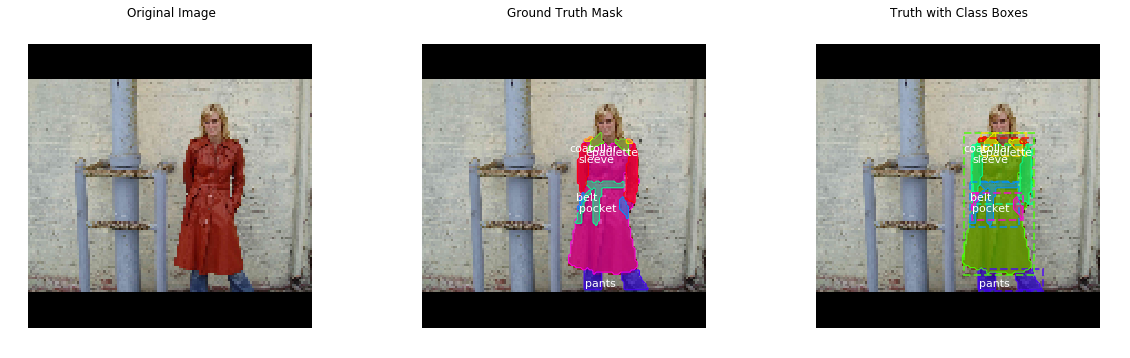

In [31]:
batch_size = 1
train_gen  = ImgMask_sequencer(  fash_val, 
                                 batch_size=batch_size,
                                 name="Validation Generator",
                                 target_shape=im_shape[0:2],
                                 color=True)

fix, ax = plt.subplots(ncols=3, figsize=(20,20), sharex=True, sharey=True)

test_image_batch, test_mask_batch = train_gen.__getitem__(55)
test_image = test_image_batch[0]
test_mask  = test_mask_batch[0]

mask, class_ids = get_unstacked_mask(test_mask)
bbox = utils.extract_bboxes(mask)


ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title("Original Image")

visualize.display_instances(test_image*255, 
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=False, show_mask=True,
                            ax=ax[1], title="Ground Truth Mask")

visualize.display_instances(test_image*255, 
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            ax=ax[2], title="Truth with Class Boxes")



Test iterating through full dataset to emulate epoch

In [33]:
batch_size = 128
val_gen  = ImgMask_sequencer( fash_val, 
                              batch_size=batch_size,
                              name="Validation Generator",
                              target_shape=im_shape[0:2],
                              color=True)

batches = len(val_gen)
for batch in tqdm(range(batches)):
    test_image_batch, test_mask_batch = val_gen.__getitem__(batch)

Creating Generator 'Validation Generator':
	batch size  :  128
	length      :  4113
	num batches :  33
	target shape:  (128, 128)
	color       :  True


Curtailed: length:4113/end4112



### Defin UNET model Structure

In [29]:
model = UNet(Input(im_shape, name='img'))
model.summary()

INFO:plaidml:Opening device "opencl_amd_radeon_rx_vega_64_compute_engine.0"


outputs shape:  Shape(dtype=<DType.FLOAT32: 50>, dims=(<tile.Value Operation UINT64()>, 128, 128, 47))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
______

### Train Model

In [30]:
def train_unet(  model,
                 train_data,
                 val_data,
                 epochs=10,
                 target_shape:tuple=(512,512,3), 
                 batch_size:int=128,
                 logs_base_dir:str="./logs",
                 color:bool=True
                 ):

    # Setup callbacks
    logdir=os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [
        EarlyStopping(patience=2, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
        ModelCheckpoint(os.path.join(logdir,'model-unet-fashion.h5'), verbose=1, save_best_only=True, save_weights_only=True),
        TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=batch_size, update_freq='batch')
    ]

    # Get generators for training and validation
    train_gen  = ImgMask_sequencer(train_data, 
                                   batch_size=batch_size,
                                   name="Train Generator",
                                   target_shape=target_shape[0:2],
                                   color=color)

    val_gen    = ImgMask_sequencer(val_data, 
                                   batch_size=batch_size,
                                   name="Val Generator",
                                   target_shape=target_shape[0:2],
                                   color=color)

#     optimizer = SGD(lr=.002,momentum=.9)
    optimizer = Adam()
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", # binary_crossentropy
                  metrics=["accuracy"])

    results = model.fit_generator(  train_gen,  
                                    epochs=epochs,
                                    callbacks=callbacks, 
                                    validation_data=val_gen)
    
    return results

In [31]:
logs_base_dir = os.path.join(data_dir, 'logs')
os.path.isdir(logs_base_dir)

True

In [16]:
# add tensorboard to notebook
%load_ext tensorboard

os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 930), started 1:14:22 ago. (Use '!kill 930' to kill it.)

In [ ]:
# Train Model
batch_size=128
epochs=2

results = train_unet(  model,
             fash_train,
             fash_val,
             epochs=epochs,
             target_shape=im_shape, 
             batch_size=batch_size,
             logs_base_dir=logs_base_dir,
             color=True)

Creating Generator 'Train Generator':
	batch size  :  128
	length      :  16452
	num batches :  129
	target shape:  (128, 128)
	color       :  True
Creating Generator 'Val Generator':
	batch size  :  128
	length      :  4113
	num batches :  33
	target shape:  (128, 128)
	color       :  True
Epoch 1/2


INFO:plaidml:Analyzing Ops: 197 of 819 operations complete


Current:
> Current: switched to softmax/categorical cross entropy

> Turning off multiple category merging

Other:
> change to sigmoid from softmax // binary_crossentropy from categorical_crossentropy
> he kernel_initialization ='he_initialization'
> updated sequenc generator for resizing issues

> change batch size to 64

> consider using Adam again (didn't help)

> consider increasing im size to 256



In [43]:
model_save_dir = os.path.join(data_dir, 'logs')
model.save(os.path.join(model_save_dir,'model-unet-fashion-2epochs-categorical.h5'))

### Visualize Masks
Conver one-hot encoded masks into displayable masks

In [1]:
batch_size = 1
train_gen  = ImgMask_sequencer(  fash_val, 
                                 batch_size=batch_size,
                                 name="Train Generator",
                                 target_shape=im_shape[0:2],
                                 color=True)

fix, ax = plt.subplots(ncols=3, figsize=(20,20), sharex=True, sharey=True)

test_image_batch, test_mask_batch = train_gen.__getitem__(2)
test_image = test_image_batch[0]
test_mask  = test_mask_batch[0]

mask, class_ids = get_unstacked_mask(test_mask)
bbox = utils.extract_bboxes(mask)

ax[0].imshow(test_image)
ax[0].axis('off')
ax[0].set_title("Original Image")

visualize.display_instances(test_image*255, 
                            bbox, 
                            mask, 
                            class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=False, show_mask=True,
                            ax=ax[1], title="Ground Truth Mask")

pred_mask_batch = model.predict(test_image_batch)
p_mask, p_class_ids = get_unstacked_mask(pred_mask_batch[0], threshold= 0.9)
p_bbox = utils.extract_bboxes(p_mask)
visualize.display_instances(test_image*255, 
                            p_bbox, 
                            p_mask*255, 
                            p_class_ids, 
                            fash_val.class_names, 
                            figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            ax=ax[2], title="Truth with Class Boxes")



NameError: name 'ImgMask_sequencer' is not defined